### Verify and update the module that independently measures the accuracy of predicted ficc_ytw on a given subset of trades


This notebook uses the get price function and the current yield curve function to get the price calculated using ficc yield and ficc ys. We want to analyze errors in yield spread (ficc_ys) and also in YTW. This notebook could do both with not much extra code.

Using USFederalHolidayCalendar etc. is I think not the best approach. A better approach is to work backwards day by day and get the most recent available information. If no information is available for five consecutive days, then raise an exception. This approach will generalize better to other point-in-time data needs.

One of Charles notebooks has an easy way to suppress warnings "A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead".

In [5]:
%load_ext autoreload
%autoreload 2

import redis
import pandas as pd
import json
import numpy as np
import requests
import subprocess
import time
import datetime
import holidays
import pandas as pd
import sklearn
import copy
import os
from tensorflow import keras
import pickle5 as pickle
from requests.api import request
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from dateutil import parser
from pytz import timezone
from numpy.core.numeric import NaN
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import storage

from ficc_pricing import get_cusip_price
from ficc_yield import get_yc_data,get_current_yield_curve
from ficc_bq import get_trades_data
from ficc_data_input_ficc_ycl import process_data,BINARY,CATEGORICAL_FEATURES,NON_CAT_FEATURES,PREDICTORS,IDENTIFIERS
import ficc_globals as globals
from ficc_utils import sqltodf, yield_curve_params
from yield_value import yield_curve_level
# from ficc_ys_model_api import get_spread,pre_processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
pd.options.mode.chained_assignment = None

In [7]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "eng-reactor-287421-112eb767e1b3.json"
eastern = timezone('US/Eastern') #We only use datetime aware datetimes in ET; naive datetimes should be localized.

In [8]:
bq_client = bigquery.Client()

## Grabbing the Nelson Siegel parameters

In [9]:
yield_curve_params(bq_client)

### Getting trades and ref data from big query

In [10]:
yield_spread_model = keras.models.load_model('yield_spread_model_ficc_ycl')

2021-12-02 18:14:35.301823: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
trades_df = get_trades_data('2021-08-24')

Reading from file
File read


In [13]:
trades_df.head()

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,MSRB_maturity_date,msrb_cusip,yield_spread,num_prev_messages,MSRB_INST_ORDR_DESC,...,purpose_class,purpose_sub_class,sp_long,sp_stand_alone,sp_icr_school,sp_prelim_long,sp_outlook_long,sp_watch_long,assumed_redemption_date,recent
0,2021082401895900,2021-08-24 11:40:01,040664EB6,104.0,0.0,2038-07-01,040664EB6,1.356835,0,1,...,9,87.0,AA,None,None,None,STABLE,None,2031-07-01,"[{'rtrs_control_number': 2021051006025000.0, '..."
1,2021082403240700,2021-08-24 13:05:30,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,37,11.0,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082403235700.0, '..."
2,2021082403235700,2021-08-24 13:05:15,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,37,11.0,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082403221300.0, '..."
3,2021082403221300,2021-08-24 13:04:24,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,37,11.0,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082401450300.0, '..."
4,2021082405288000,2021-08-24 15:17:03,74176HAS4,104.0,0.0,2046-11-01,74176HAS4,-0.396165,0,1,...,17,48.0,AA-,None,None,None,STABLE,None,2022-11-01,"[{'rtrs_control_number': 2021082405163600.0, '..."


In [14]:
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5
trades_df['quantity'] = trades_df.par_traded

In [15]:
trades_df["orig_interest_payment_frequency"] = trades_df.interest_payment_frequency
trades_df.head()

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,MSRB_maturity_date,msrb_cusip,yield_spread,num_prev_messages,MSRB_INST_ORDR_DESC,...,sp_long,sp_stand_alone,sp_icr_school,sp_prelim_long,sp_outlook_long,sp_watch_long,assumed_redemption_date,recent,quantity,orig_interest_payment_frequency
0,2021082401895900,2021-08-24 11:40:01,040664EB6,104.0,0.0,2038-07-01,040664EB6,1.356835,0,1,...,AA,None,None,None,STABLE,None,2031-07-01,"[{'rtrs_control_number': 2021051006025000.0, '...",200000.000000000,1
1,2021082403240700,2021-08-24 13:05:30,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082403235700.0, '...",10000.000000000,1
2,2021082403235700,2021-08-24 13:05:15,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082403221300.0, '...",10000.000000000,1
3,2021082403221300,2021-08-24 13:04:24,540261KH6,104.0,0.0,2029-08-01,540261KH6,-0.310165,0,1,...,AA,A+,None,None,STABLE,None,2022-08-01,"[{'rtrs_control_number': 2021082401450300.0, '...",20000.000000000,1
4,2021082405288000,2021-08-24 15:17:03,74176HAS4,104.0,0.0,2046-11-01,74176HAS4,-0.396165,0,1,...,AA-,None,None,None,STABLE,None,2022-11-01,"[{'rtrs_control_number': 2021082405163600.0, '...",45000.000000000,1


In [16]:
trades_df = process_data(trades_df, SEQUENCE_LENGTH, NUM_FEATURES)

Dropping empty trades
Dropping trades less that 10000$
Estimating calculation date
Creating trade history
Trade history created
Calculating Yield Spreads


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Sanity check that the spreads are calculated using ficc yield curve level

In [17]:
trades_df[['rtrs_control_number','yield','ficc_ycl','yield_spread']]

,rtrs_control_number,yield,ficc_ycl,yield_spread
0,2021082401895900,2.347,81.003425,153.696575
3,2021082403221300,0.680,6.024997,61.975003
4,2021082405288000,0.594,8.278107,51.121893
5,2021082402817700,1.175,37.361344,80.138656
6,2021082402809900,1.175,37.361344,80.138656
...,...,...,...,...
17221,2021082400463200,0.600,37.618251,22.381749
17223,2021082405179900,1.250,62.627284,62.372716
17224,2021082404943600,2.000,100.948804,99.051196
17225,2021082400975500,2.125,117.827568,94.672432


### Main

In [18]:
trades_df.head()

,rtrs_control_number,trade_datetime,cusip,my_price,price_delta,MSRB_maturity_date,msrb_cusip,yield_spread,num_prev_messages,MSRB_INST_ORDR_DESC,...,settle_pace,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,last_seconds_ago,last_yield_spread,last_size,ficc_ycl
0,2021082401895900,2021-08-24 11:40:01,040664EB6,104.0,0.0,2038-07-01,040664EB6,153.696575,0,1,...,Fast,3.789157,3.555940,0.000000,3.555940,3.407901,6.961102,208.642781,5.301030,81.003425
3,2021082403221300,2021-08-24 13:04:24,540261KH6,104.0,0.0,2029-08-01,540261KH6,61.975003,0,1,...,Fast,3.462098,2.532754,0.000000,2.532754,3.407901,3.837020,158.925947,4.397940,6.024997
4,2021082405288000,2021-08-24 15:17:03,74176HAS4,104.0,0.0,2046-11-01,74176HAS4,51.121893,0,1,...,Fast,3.963741,2.636488,2.636488,2.636488,3.942851,2.608526,28.172991,4.653213,8.278107
5,2021082402817700,2021-08-24 12:37:02,591840AQ6,108.0,0.0,2031-03-01,591840AQ6,80.138656,0,1,...,Fast,3.540955,3.217221,0.000000,3.217221,3.261739,4.896377,102.607916,4.301030,37.361344
6,2021082402809900,2021-08-24 12:36:23,591840AQ6,108.0,0.0,2031-03-01,591840AQ6,80.138656,0,1,...,Fast,3.540955,3.217221,0.000000,3.217221,3.261739,4.896162,102.607916,4.301030,37.361344


In [19]:
pd.set_option('display.max_columns', None)
trades_df[['ficc_yield','ficc_price','calc_method','status']] = 0

In [20]:
# trades_df['duration'] = (trades_df['calc_date'] - trades_df['settlement_date'])
# trades_df.duration = trades_df.duration.apply(lambda x:x.days)

In [21]:
# trades_df = trades_df[trades_df.duration > 365.25]

Reading the saved encoders

In [22]:
encoders = None
with open('encoders.pkl','rb') as file:
    encoders = pickle.load(file)

In [23]:
# There is no point in modularizing work in progress code: 
# it slows development and makes debugging and coding harder. 
# The Kernel needs more restart. 
# Code should only be in the py module once we do not need to touch it anymore. 
    
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history_input'].to_numpy()))
    for f in NON_CAT_FEATURES + BINARY:
        datalist.append(df[f].to_numpy().astype('float32'))
        
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    return datalist

def get_spread(df):

    '''
    This function takes a dataframe, encodes the features, and returns yield spread estimates.
    NB: This is only used by get_prediction_from_individual_pricing.  In order to be DRY, get_BB11_table and get_ytw_curve
    should also use this function. 
    '''
    
    inputs = create_input(df)
    
    global yield_spread_model
    preds = yield_spread_model.predict(inputs)
    preds = preds.reshape(len(preds))
    return preds

In [24]:
predicted_spreads = get_spread(trades_df[PREDICTORS + ['yield_spread']])

2021-12-02 18:16:42.950519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=40

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=160
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=

OMP: Info #249: KMP_AFFINITY: pid 18926 tid 19136 thread 40 bound to OS proc set 0
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20002 thread 42 bound to OS proc set 2
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20001 thread 41 bound to OS proc set 1
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20003 thread 43 bound to OS proc set 3
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20005 thread 45 bound to OS proc set 5
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20004 thread 44 bound to OS proc set 4
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20006 thread 46 bound to OS proc set 6
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20007 thread 47 bound to OS proc set 7
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20008 thread 48 bound to OS proc set 8
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20009 thread 49 bound to OS proc set 9
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20010 thread 50 bound to OS proc set 10
OMP: Info #249: KMP_AFFINITY: pid 18926 tid 20012 thread 52 bound to OS proc set 12
OM

In [25]:
trades_df['ficc_spreads'] = predicted_spreads

Function to get yield curve level at the time of the trade

In [26]:
def get_ficc_ycl(trade):
    duration = (trade.calc_date - trade.settlement_date).days/365.25
    ficc_yl = yield_curve_level(duration,
                                trade.trade_date.strftime('%Y-%m-%d'),
                                globals.nelson_params, 
                                globals.scalar_params)
    return ficc_yl

In [27]:
trades_df['ficc_ycl'] = trades_df.apply(get_ficc_ycl, axis=1)              

In [29]:
trades_df['ficc_ytw'] = (trades_df.ficc_ycl + trades_df.ficc_spreads)/100

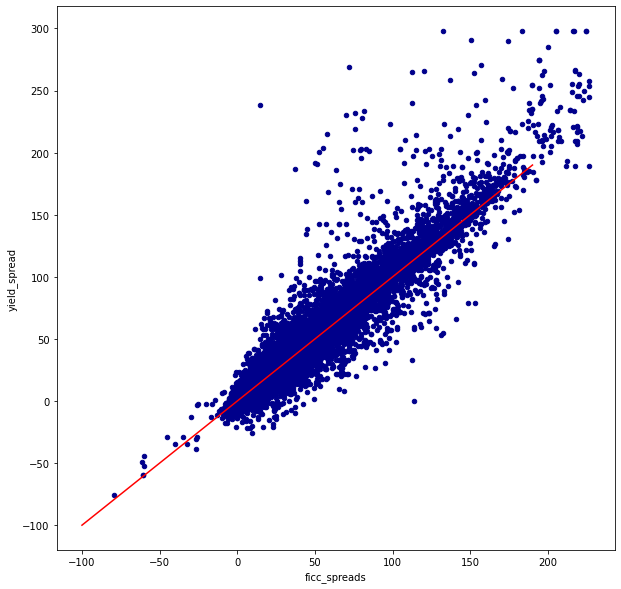

In [30]:
fig_spread, ax_spread = plt.subplots()
x = np.arange(-100, 200, 10)
trades_df.plot.scatter(x='ficc_spreads', y='yield_spread', c='DarkBlue', figsize=(10,10), ax = ax_spread)
ax_spread.plot(x,x,'r-')

Priced to calc date

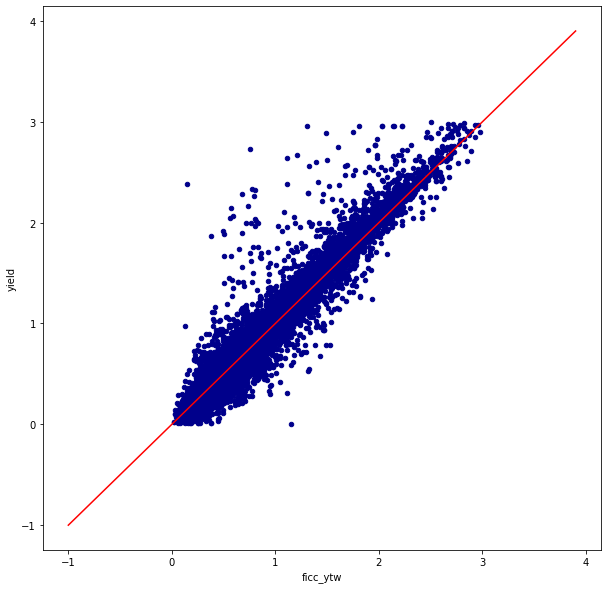

In [36]:
fig_ytw, ax_ytw = plt.subplots()
x = np.arange(-1,4,0.1)
trades_df.plot.scatter(x='ficc_ytw', y='yield', c='DarkBlue', figsize=(10,10), ax = ax_ytw)
ax_ytw.plot(x,x,'r-')